In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

class MonteCarloMilstein:
    def __init__(self, s0, mu, sigma, T, N, M):
        """
        params:
        - s0: Initial stock price
        - mu: Drift coefficient
        - sigma: Volatility coefficient
        - T: Time horizon
        - N: Number of time steps
        - M: Number of simulations
        """
        
        self.s0 = s0
        self.mu = mu
        self.sigma = sigma
        self.T = T
        self.N = N
        self.M = M
        self.dt = T / N
        self.paths = None  # before simulating

    def simulate(self):
        """
        simulate Milstein
        """
        dt = self.dt # dt is time step size (T/N)
        
        s0, mu, sigma = self.s0, self.mu, self.sigma
        
        # creating an array sized (N+1 x M). N+1 accounts for the initial price
        # and M is the number of simulations
        # paths[0] = s0  --- sets the first row of paths to initial stock price
        
        paths = np.zeros((self.N + 1, self.M)) 
        paths[0] = s0
        
        # dw is used as increments of the Wiener process.
        
        dW = np.random.normal(0, np.sqrt(dt), (self.N, self.M))
        
        # the for loop iterates over each step t from 1 to N
        # each time step contains:
        # St - stok prices at t-1
        # The Milstein scheme updates the stock prices for t using formula under
        # mu*St*dt - deterministic drift term
        # sigma*st*dW[t-1] - stochastic term
        # last term - correction term from Milstein scheme
        
        for t in range(1, self.N + 1):
            St = paths[t-1]
            paths[t] = St + mu * St * dt + sigma * St * dW[t-1] + 0.5 * sigma**2 * St * (dW[t-1]**2 - dt)
        
        self.paths = paths
        return paths

    def calibrate(self, market_data):
        """
        calibration - input: market_data, output: optimal mu,sigma
        """
        # creating an array for mu and sigma
        
        def objective(params):
            self.mu, self.sigma = params
            simulated_paths = self.simulate() # simulating for curretn mu and sigma
            
            # sim_vol is standard deviation of asset prices at the last step
            # market_vol is the standard deviation of given market_data
            simulated_vol = np.std(simulated_paths[-1]) 
            market_vol = np.std(market_data)
            
            # returns the squared difference of sim_vol and market_vol. Our target to minimize
            return (simulated_vol - market_vol)**2
        
        # searching for mu and sigma that minimize the objective function
        result = minimize(objective, [self.mu, self.sigma], bounds=[(0, None), (0, None)])
        self.mu, self.sigma = result.x
        return self.mu, self.sigma

    def plot_paths(self):
        if self.paths is None:
            
            # if before simulating
            
            raise ValueError("No simulation paths available.")
        
        plt.figure(figsize=(10, 6))
        plt.plot(self.paths)
        plt.title('Monte Carlo Simulation w/ Milstein Scheme')
        plt.xlabel('Time Steps')
        plt.ylabel('Asset Price')
        plt.grid(True)
        plt.show()

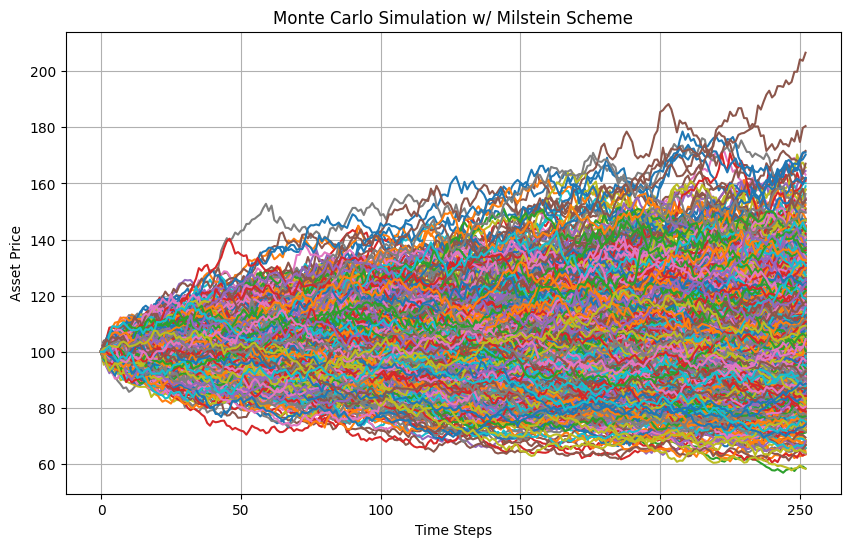

In [14]:
s0 = 100       # Initial stock price
mu = 0.05      # Drift coefficient
sigma = 0.2    # Volatility coefficient
T = 1          # Time horizon   1=1year
N = 252        # Number of time steps 1=1day
M = 1000       # Number of simulations - each color curve is one path

mc_simulator = MonteCarloMilstein(s0, mu, sigma, T, N, M)

paths = mc_simulator.simulate()

mc_simulator.plot_paths()

Optimal mu: 0.050011180107619714, Optimal sigma: 0.20000418092587477


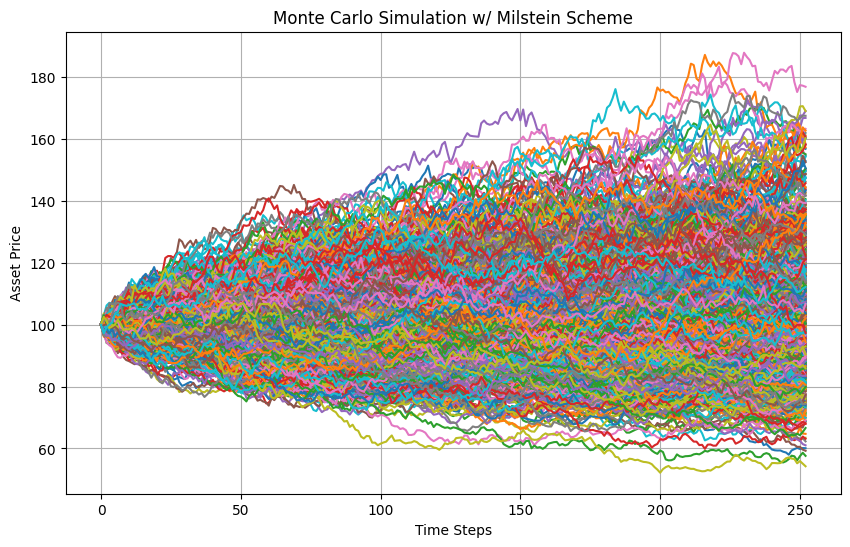

In [15]:
# calibrating the model, simulating it on optimal data and then pltoing it's paths

market_data = np.random.normal(100, 20, 1000) 

optimal_mu, optimal_sigma = mc_simulator.calibrate(market_data)
print(f"Optimal mu: {optimal_mu}, Optimal sigma: {optimal_sigma}")

calibrated_paths = mc_simulator.simulate()

mc_simulator.plot_paths()